# Project 2 Ames Housing
## Pipeline linear modeling

This approach closely follows that presented in class by Mark Popovich and references notes by Douglas Strodtman (SaMo).  


## Import libraries

In [53]:
# Imports:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, RFE

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV

from scipy import stats
import statsmodels.api as sm

from itertools import combinations

%matplotlib inline

# Set the graph style
sns.set_style('whitegrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [54]:
# Set relative data path
data_path = "../datasets"
test_dataframe_name = "test_clean.csv"
train_dataframe_name = "train_clean.csv"
y_trn_dataframe_name = "y_clean.csv"

X1_trn = pd.read_csv(os.path.join(data_path, train_dataframe_name))
X1_tst = pd.read_csv(os.path.join(data_path, test_dataframe_name))
y_trn = pd.read_csv(os.path.join(data_path, y_trn_dataframe_name))

print(X1_trn.shape, X1_tst.shape, y_trn.shape)

(2051, 132) (879, 132) (2051, 1)


In [55]:
# Establish lists of variable types
cat_features = ['ms_subclass', 'ms_zoning', 'util', 'lot_config',
                'neigh', 'bld_type', 'hs_style', 
                'ext_qual', 'ext_cond', 'bsmt_cond', 'heat_qc', 'cen_air',
                'kit_qual', 'funct','garag_type', 'pool_qc', 'misc_feat','sale_type']

num_features = ['lot_area', 'over_qual', 'over_cond', 'age_home_at_sale',
                'age_remodel_at_sale', 'tot_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
                'bsmt_half_bath', 'full_bath', 'half_bath', 'bed_abvgr',
                'enc_porch', 'mon_sold', 'yr_sold']


### Use polynomial features to add higher order terms

In [56]:
# Consider only interaction terms of the numerical columns
poly = PolynomialFeatures(interaction_only = True, include_bias = False)
X1_trn_p = pd.DataFrame(poly.fit_transform(X1_trn[num_features]))
X1_trn_p.columns = poly.get_feature_names(num_features)

X1_tst_p = pd.DataFrame(poly.fit_transform(X1_tst[num_features]))
X1_tst_p.columns = poly.get_feature_names(num_features)


In [57]:
X1_trn_temp = X1_trn.drop(columns = num_features)
X1_tst_temp = X1_tst.drop(columns = num_features)

print(X1_trn_p.shape)
print(X1_tst_p.shape)
print(X1_trn_temp.shape)
print(X1_tst_temp.shape)


(2051, 120)
(879, 120)
(2051, 117)
(879, 117)


In [58]:
# recombine with the categorical variables
X1_trn = X1_trn_p.join(X1_trn_temp)
X1_tst = X1_tst_p.join(X1_tst_temp)
print(X1_trn.shape)
print(X1_tst.shape)



(2051, 237)
(879, 237)


### Split the training data into training and testing subsets

In [59]:
# Split the training data
X1_trn_trn, X1_trn_tst, y_trn_trn, y_trn_tst = train_test_split(X1_trn, y_trn, random_state=223)


### Scale the data

In [60]:
# Use the standard scaler to scale the data
ss = StandardScaler()
ss.fit(X1_trn_trn)
X1_trn_trn_s = pd.DataFrame(ss.transform(X1_trn_trn))
X1_trn_trn_s.columns = X1_trn_trn.columns
X1_trn_tst_s = pd.DataFrame(ss.transform(X1_trn_tst))
X1_trn_tst_s.columns = X1_trn_tst.columns


## Define functions


In [84]:
def eval_model(y_act, y_pred):
    
    # Make a copy of the y_act dataframe
    df = y_act.copy()
    # Copy y_pred into the data frame
    try:
        df['pred'] = [x[0] for x in y_pred]
    except:
        df['pred'] = [x for x in y_pred]
    
    df.columns=['act','pred']
    # create residuals
    df['res'] = df['act'] - df['pred']
    # get the r2 score
    r2 = r2_score(df['act'], df['pred'])
    # do the normality test
    k2, p = stats.normaltest(df['res'])
    
    # specify your figsize and the number of plots on that figure
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15,12))

    fig.suptitle('Model analysis', fontsize = 16)
    
    # Plot the scatter of the predicted versus actual
    ax[0][0] = sns.scatterplot('act','pred', data=df, ax = ax[0][0])
    ax[0][0] = sns.lineplot('act','act', data=df, ax = ax[0][0], color = 'grey')
    ax[0][0].set_title('Predicted versus actuals', fontsize = 14)
    ax[0][0].set_xlabel('Actuals', fontsize = 12)
    ax[0][0].set_ylabel('Predicted', fontsize = 12)
    ax[0][0].text(.25, .75, f"$R^2$ {r2:.4}", horizontalalignment='left',
                  size='large', color='grey', weight='semibold', transform=ax[0][0].transAxes)
    ax[0][0].grid(False)
    
    # Plot the scatter of the residuals versus actuals
    ax[0][1] = sns.scatterplot(x = 'act',y = 'res', data=df, ax = ax[0][1])
    ax[0][1].set_title('Residuals versus actuals', fontsize = 14)
    ax[0][1].set_xlabel('Actuals', fontsize = 12)
    ax[0][1].set_ylabel('Residuals', fontsize = 12)
    ax[0][1].axhline(y=0, color = 'grey')
    ax[0][1].grid(False)
    
    # Plot the residuals
    ax[1][0] = sns.scatterplot(x = df.index,y = 'res', data=df, ax = ax[1][0])
    ax[1][0].set_title('Residuals versus an index', fontsize = 14)
    ax[1][0].set_xlabel('Index', fontsize = 12)
    ax[1][0].set_ylabel('Residuals', fontsize = 12)
    ax[1][0].axhline(y=0, color = 'grey')
    ax[1][0].grid(False)
    
    # Plot the histogram of residuals
    ax[1][1] = sns.distplot( df['res'], ax = ax[1][1])
    ax[1][1].set_title('Histogram of residuals', fontsize = 14)
    ax[1][1].set_xlabel('Residuals', fontsize = 12)
    ax[1][1].set_ylabel('Distribution', fontsize = 12)
    ax[1][1].text(.05,.95, f"p value for $H_0$: residuals are normal {r2:.4}", 
                  horizontalalignment='left', size='large', color='grey', weight='semibold', 
                  transform=ax[1][1].transAxes)
    ax[1][1].grid(False)
    
    # https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
    # https://www.blog.pythonlibrary.org/2018/03/13/python-3-an-intro-to-f-strings/
    # https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html


def write_pred(df, out_file):
    # Open the test file to get the ID
    test_file_name = "test.csv"
    a_tst = pd.read_csv(os.path.join(data_path, test_file_name))
    pred_out = a_tst[['Id']].join(df).sort_values(by='Id')
    # Save the predictions to a csv file
    pred_out.to_csv(os.path.join(data_path, out_file), header = ['Id','SalePrice'], index = False)
    
    # https://stackoverflow.com/questions/26097916/convert-pandas-series-to-dataframe
    # https://www.blog.pythonlibrary.org/2018/03/13/python-3-an-intro-to-f-strings/

    
def view_lr_summary(X,y):    
    # Use stats models to generate a summary of the regression
    # Copy the X and y and reset index of y to be equal to x
    X1 = X.copy()
    y1 = y.copy()
    y1.index = X1.index
    X1 = sm.add_constant(X1)
    model = sm.OLS(y1, X1)
    results =  model.fit()
    # return the results
    return results.summary()


## Work with a pipeline

### Create a pipe

In [62]:
# Create a pip
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('kbest',SelectKBest(f_regression, k = 10)),
    ('rfe', RFE(Lasso(),n_features_to_select=None))
])


### Establish a grid

In [65]:
# Establish the grid parameters to search
# In this case we are calling the kbesdt evaluation object and 
# and Recursive Feature Elimination (RFE)
params = {
    'kbest__k': [10, 20, 30, 40, 50],
    'rfe__n_features_to_select': [5, 7, 9, 11, 20, 30]
}


In [66]:
# Instantiate the grid search object
gs_model = GridSearchCV(pipe, params)


### Fit and score the model

In [67]:
# fit the model
gs_model.fit(X1_trn_trn_s, y_trn_trn)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a1865e400>)), ('rfe', RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=None, step=1, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': [10, 20, 30, 40, 50], 'rfe__n_features_to_select': [5, 7, 9, 11, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [68]:
# Generate predictions from the 
pred_gs_trn_tst = gs_model.predict(X1_trn_tst_s)


In [69]:
# score the training data
print(gs_model.score(X1_trn_trn_s, y_trn_trn))
print(gs_model.score(X1_trn_tst_s, y_trn_tst))


0.8963597048027756
0.8799270360938812


## Evaluate the model

### Use the eval_model function to examine predictions and residuals

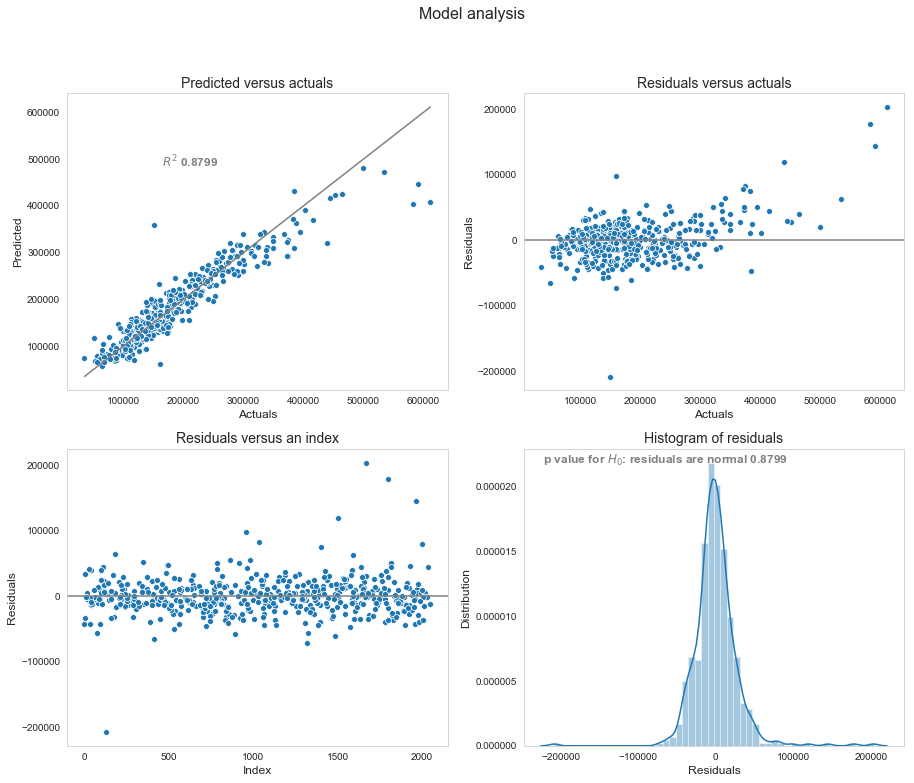

In [85]:
# Examine the model's performance
eval_model(y_trn_tst, pred_gs_trn_tst)


## Examine the model

In [71]:
# Get the kbest parameters
print(gs_model.best_estimator_.named_steps['kbest'])

print(gs_model.best_estimator_.named_steps['rfe'])


SelectKBest(k=40, score_func=<function f_regression at 0x1a1865e400>)
RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=20, step=1, verbose=0)


## Examine the intercept and coefficients

In [72]:
# Look at the variables after the transformations
columns = X1_trn.columns
columns = columns[gs_model.best_estimator_.named_steps['kbest'].get_support()]
columns = columns[gs_model.best_estimator_.named_steps['rfe'].get_support()]
print(columns)

Index(['over_qual', 'gr_liv_area', 'lot_area over_qual',
       'lot_area tot_bsmt_sf', 'lot_area gr_liv_area',
       'over_qual age_remodel_at_sale', 'over_qual tot_bsmt_sf',
       'over_qual gr_liv_area', 'over_qual full_bath', 'over_qual yr_sold',
       'over_cond age_remodel_at_sale', 'over_cond tot_bsmt_sf',
       'age_home_at_sale yr_sold', 'tot_bsmt_sf gr_liv_area',
       'tot_bsmt_sf full_bath', 'gr_liv_area bsmt_full_bath',
       'gr_liv_area full_bath', 'gr_liv_area yr_sold', 'ext_qual_Gd',
       'ext_qual_TA'],
      dtype='object')


In [86]:
# get the intercept and coefficients
intercept = gs_model.best_estimator_.named_steps['rfe'].estimator_.intercept_
coefficients = gs_model.best_estimator_.named_steps['rfe'].estimator_.coef_


## Get the coefficients


In [74]:
model = pd.DataFrame(coefficients, index = columns, columns=['coeff'])
model

,coeff
over_qual,67684.156372
gr_liv_area,13589.345093
lot_area over_qual,31024.145732
lot_area tot_bsmt_sf,-16500.516359
lot_area gr_liv_area,-11938.712967
over_qual age_remodel_at_sale,-19142.819149
over_qual tot_bsmt_sf,42920.854871
over_qual gr_liv_area,68970.606233
over_qual full_bath,-32311.013711
over_qual yr_sold,-80346.669977


## Look at these variables in a ordinary linear regression model



In [75]:
# look at these results in a linear regression model
view_lr_summary(X1_trn_trn_s[columns],y_trn_trn)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     656.5
Date:                Tue, 19 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:36:01   Log-Likelihood:                -17770.
No. Observations:                1538   AIC:                         3.558e+04
Df Residuals:                    1517   BIC:                         3.569e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          1.821e+05    647.115    281.371      0.000    1.81e+05    1.83e+05
over_qual                     -6.589e+05   8.92e+05     -0.738      0.460   -2.41e+06    1.09e+06
gr_liv_area                     8.13e+05   1.25e+06      0.650      0.516   -1.64e+06    3.27e+06
lot_area over_qual              3.11e+04   3781.148      8.225      0.000    2.37e+04    3.85e+04
lot_area tot_bsmt_sf          -1.643e+04   3581.369     -4.588      0.000   -2.35e+04   -9404.729
lot_area gr_liv_area           -1.21e+04   2718.128     -4.451      0.000   -1.74e+04   -6766.149
over_qual age_remodel_at_sale -1.929e+04   2424.214     -7.957      0.000    -2.4e+04   -1.45e+04
over_qual tot_bsmt_sf          4.295e+04   4142.212     10.368      0.000    3.48e+04    5.11e+04
over_qual gr_liv_area          6.906e+04   5958.850     11.589      0.000    5.74e+04    8.07e+04
over_qual full_bath           -3.275e+04   4625.283     -7.080      0.000   -4.18e+04   -2.37e+04
over_qual yr_sold              6.463e+05   8.92e+05      0.724      0.469    -1.1e+06     2.4e+06
over_cond age_remodel_at_sale  1.564e+04   2471.249      6.329      0.000    1.08e+04    2.05e+04
over_cond tot_bsmt_sf          8975.8208   1641.537      5.468      0.000    5755.899    1.22e+04
age_home_at_sale yr_sold      -1.189e+04   1043.700    -11.394      0.000   -1.39e+04   -9844.293
tot_bsmt_sf gr_liv_area       -4.948e+04   4827.190    -10.250      0.000   -5.89e+04      -4e+04
tot_bsmt_sf full_bath          1.645e+04   4069.586      4.042      0.000    8466.980    2.44e+04
gr_liv_area bsmt_full_bath     8330.7734    745.815     11.170      0.000    6867.837    9793.710
gr_liv_area full_bath          2.135e+04   4657.703      4.583      0.000    1.22e+04    3.05e+04
gr_liv_area yr_sold           -8.164e+05   1.25e+06     -0.653      0.514   -3.27e+06    1.64e+06
ext_qual_Gd                   -8864.9701   1650.115     -5.372      0.000   -1.21e+04   -5628.223
ext_qual_TA                   -1.034e+04   1897.140     -5.450      0.000   -1.41e+04   -6618.308
==============================================================================
Omnibus:                      286.711   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2275.018
Skew:                           0.638   Prob(JB):                         0.00
Kurtosis:                       8.820   Cond. No.                     1.09e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Train the model on the entire training data set

In [76]:
# Update the scalar to include all of the data in the training set
ss = StandardScaler()
ss.fit(X1_trn)
X1_trn_s = pd.DataFrame(ss.transform(X1_trn))
X1_trn_s.columns = X1_trn.columns
X1_tst_s = pd.DataFrame(ss.transform(X1_tst))
X1_tst_s.columns = X1_tst.columns


In [77]:
# fit the model
gs_model.fit(X1_trn_s, y_trn)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x1a1865e400>)), ('rfe', RFE(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
  n_features_to_select=None, step=1, verbose=0))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': [10, 20, 30, 40, 50], 'rfe__n_features_to_select': [5, 7, 9, 11, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [78]:
# Generate predictions from the grid search model
pred_gs_tst = gs_model.predict(X1_tst_s)


## Write data to files

### Write the predictions to a file

In [79]:
# write the test set predictions to a file
write_pred(pd.DataFrame(pred_gs_tst),"pred_4_Steve_Godfrey.csv" )


### Write the expanded data frame to a file

In [80]:
# Save the data to csv files
test_dataframe_name = "test_expanded_clean.csv"
train_dataframe_name = "train_expanded_clean.csv"

X1_tst.to_csv(os.path.join(data_path, test_dataframe_name), index = False)
X1_trn.to_csv(os.path.join(data_path, train_dataframe_name), index = False)


## References

* https://machinelearningmastery.com/feature-selection-machine-learning-python/
* https://stackoverflow.com/questions/34204898/how-to-get-the-coefficients-from-rfe-using-sklearn
